In [95]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
import os
import torch
import matplotlib.pyplot as plt
from scripts.mri.logger import Logger
from tqdm.notebook import tqdm
from typing import Callable, Union, Dict, Any

from utils.makepath import makepath as mkp
from config.config_loader import load_config
from data.mri.data_loader import get_data_loader
from scripts.mri.epoch import perform_epoch
from scripts.mri.test_utils import \
    get_data_config_and_models, get_test_dataset, test_sample_and_save_images
from utils.data_util import DataUtil as GeneralDataUtil
from encoding_objects.cart_2d_enc_obj import Cart2DEncObj
from utils.metrics import ImageMetricsEvaluator

In [97]:
device = "cpu"
# device = "cuda"

In [98]:
root_dir = mkp("..", "..")

In [99]:
data_config, u_tv_net, u_tgv_net = get_data_config_and_models(
    device=device, root_dir=root_dir)

Config loaded from file ../../scripts/mri/pretrained/u_tv/config.yaml
Config loaded from dict
Norm of operator A: 1
Norm of gradient operator nabla: 2.8284270763397217
L: 3.0
u_tv model loaded
Config loaded from file ../../scripts/mri/pretrained/u_tgv/config.yaml
Config loaded from dict
Norm of operator A: 1
Norm of gradient operator nabla: 2.8284270763397217
L: 3.0
u_tgv model loaded


In [100]:
print(f"U-TV sigma: {u_tv_net.sigma}")
print(f"U-TV tau: {u_tv_net.tau}")

U-TV sigma: 0.3413746953010559
U-TV tau: 0.3254814147949219


In [101]:
print(f"U-TGV sigma: {u_tgv_net.sigma}")
print(f"U-TGV tau: {u_tgv_net.tau}")

U-TGV sigma: 0.16954700648784637
U-TGV tau: 0.6553410887718201


In [102]:
test_dataset = get_test_dataset(
    data_config=data_config,
    device=device,
    acceleration_factor_R=8,
    gaussian_noise_standard_deviation_sigma=0.05
)



Ground truth data shape: torch.Size([302, 320, 320])
min abs val of ground truth: 1.8633207901075366e-06
max abs val of ground truth: 1.385725498199463

Corrupted data shape: torch.Size([302, 320, 320])
min abs val of corrupted: 2.1736816506745527e-06
max abs val of corrupted: 1.1920750141143799

Corrupted kdata shape: torch.Size([302, 1, 320, 320])

kmasks shape: torch.Size([302, 320, 320])



In [103]:
data_util = GeneralDataUtil(device=device)

In [104]:
enc_obj = Cart2DEncObj()

In [105]:
metrics_evaluator = ImageMetricsEvaluator(
    complex_to_real_conversion="abs", device=device)

NOTE: Complex-to-real conversion method: abs


In [106]:
out_dir = mkp(".", str(device))
os.makedirs(out_dir, exist_ok=True)
print(f"Output directory: {out_dir}")

Output directory: cuda


batch_x_corrupted.shape = torch.Size([1, 320, 320])
batch_x_true.shape = torch.Size([1, 320, 320])
batch_kdata_corrupted.shape = torch.Size([1, 1, 320, 320])
batch_undersampling_kmask.shape = torch.Size([1, 320, 320])
Reconstructing with U-TGV ...


  0%|          | 0/256 [00:00<?, ?it/s]

Reconstructing with U-TV ...


  0%|          | 0/256 [00:00<?, ?it/s]

Saving kdata image
Saving ground_truth image
Saving mask image
Saving kdata_corrupted image
Saving zero_filled image
abs - zero_filled metrics: PSNR = 24.00, SSIM = 0.6221
Saving lambda image
Saving u_tv image
abs - u_tv metrics: PSNR = 26.88, SSIM = 0.7273
Saving lambda0_w image
Saving lambda1_v image
Saving u_tgv image
abs - u_tgv metrics: PSNR = 27.59, SSIM = 0.7836
Saving lambda0_w_over_lambda1_v image


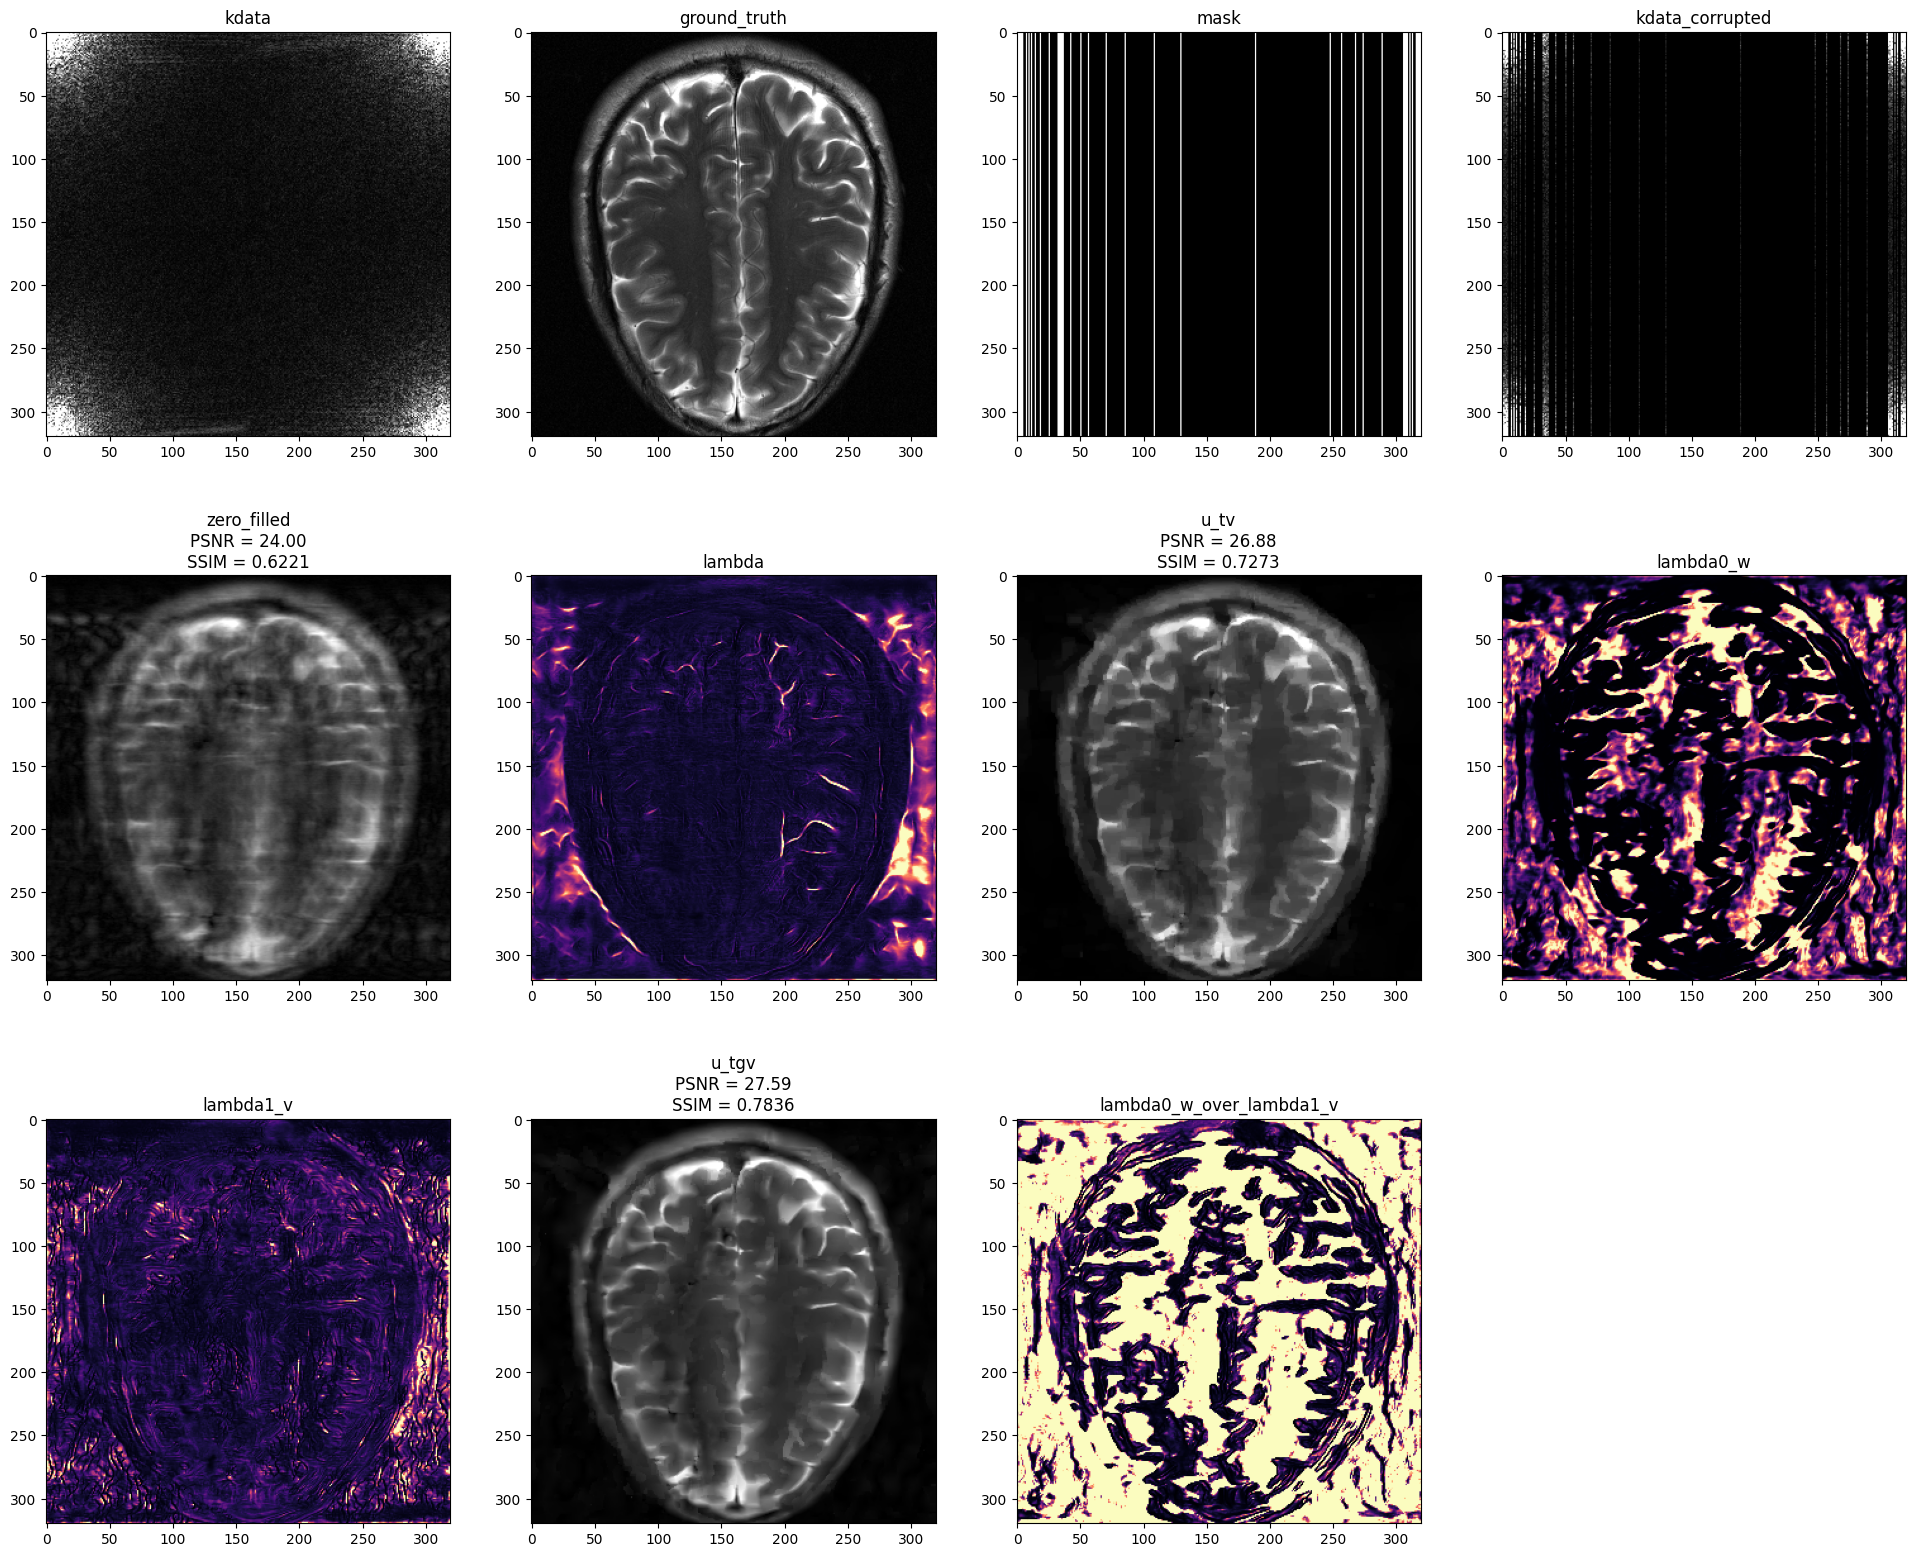

In [107]:
plt.figure(figsize=(24, 20))
test_sample_and_save_images(
    saves=False,
    sample_idx=0,
    dataset=test_dataset,
    enc_obj=enc_obj,
    u_tv_net=u_tv_net,
    u_tgv_net=u_tgv_net,
    num_iters=256,

    out_dir=out_dir,
    metrics_evaluator=metrics_evaluator,
    x_clip_range=(0, 0.5),
    kdata_clip_range=(0, 0.2),
    lambda1_v_clip_range=(0, 0.05),
    lambda0_w_clip_range=(0, 1),
    lambda_ratio_clip_range=(0, 10),
    tqdm_progress_bar=tqdm
)
plt.show()


In [108]:
def get_zero_filled(
    kdata,
    kmask,
    x,
    csmap
):
    return x, None

In [109]:
def test_and_save_results(
        config: Dict[str, Any],
        reconstructor: Union[torch.nn.Module, Callable],
        general_action: str,
        acceleration_factor_R: int,
        sigma: float,
        force_overwrite: bool = False
):
    print(f"Testing with {general_action} data, R = {acceleration_factor_R}, sigma = {sigma}")

    test_data_loader = get_data_loader(
        config=config,
        action=general_action,
        dataset_type="preprocessed",
        device=device,
        acceleration_factor_R=acceleration_factor_R,
        gaussian_noise_standard_deviation_sigma=sigma
    )

    specific_action = f"{general_action}-R_{acceleration_factor_R}-sigma_{sigma:.2f}".replace(".", "_")

    test_logger = Logger(
        action=specific_action,
        config=config,
        force_overwrite=force_overwrite
    )
    test_logger.init_metrics_logging_options()
    # Set the intermediate log frequency to 1
    test_logger.log_freq_by_iter["intermediate"] = 1

    avg_metrics = perform_epoch(
        data_loader=test_data_loader,
        pdhg_net=reconstructor,
        is_training=False,
        logger=test_logger,
        # learning_rate_scheduler=None,
        # optimizer=None,
        tqdm_progress_bar=tqdm
    )
    return avg_metrics

In [110]:
zero_filled_config = load_config(
    config_choice=mkp(root_dir, "config", "zero_filled_config.yaml"),
    is_training=False,
    root_dir=root_dir
)

Config loaded from file ../../config/zero_filled_config.yaml


In [111]:
# acceleration_factor_R = 4
# sigma = 0.15
# general_action = "test"
# # action = "val"
# force_overwrite = False
# # force_overwrite = True

for acceleration_factor_R in []:
    for sigma in []:
        test_and_save_results(
            config=zero_filled_config,
            reconstructor=get_zero_filled,
            general_action="test",
            acceleration_factor_R=acceleration_factor_R,
            sigma=sigma,
            # force_overwrite=False
            force_overwrite=True
        )